# Titanic Dataset

## Lib Imports

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
RANDOM_STATE = 123

## 1. Dataset Loading

In [5]:
train_df = pd.read_csv('train.csv')

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### 1.1 Missing Dataset Analysis

In [8]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Three columns are missing values within the training dataset:

* Age: 177 missing values which is significant as age was likely a significant factor in the survival on the Titanic.
* Cabin: missing substantial values but not likely significant so can also be removed.
* Embarked: only missing two entries so can probably just be removed.

In [9]:
empty_age_mask = (train_df['Age'].isna())

In [10]:
empty_age_df = train_df[empty_age_mask]
empty_age_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


### 1.2 Title Extraction

It may be worth investigating whether there titles in the names can be used to help fill in missing age values.

Start by creating a list of components of the name string split by ','.

In [11]:
passenger_names = train_df['Name'].str.split(',')
passenger_names

0                             [Braund,  Mr. Owen Harris]
1      [Cumings,  Mrs. John Bradley (Florence Briggs ...
2                              [Heikkinen,  Miss. Laina]
3        [Futrelle,  Mrs. Jacques Heath (Lily May Peel)]
4                            [Allen,  Mr. William Henry]
                             ...                        
886                             [Montvila,  Rev. Juozas]
887                      [Graham,  Miss. Margaret Edith]
888          [Johnston,  Miss. Catherine Helen "Carrie"]
889                             [Behr,  Mr. Karl Howell]
890                               [Dooley,  Mr. Patrick]
Name: Name, Length: 891, dtype: object

Next create a list of titles by splitting the second list value by ' ' and taking the first entry.

In [12]:
titles = [passenger_name[1].lstrip().split(' ')[0][:-1] for passenger_name in passenger_names]

In [13]:
print(f"num titles {len(titles)}")

num titles 891


Converting to a set.

In [14]:
title_set = set(titles)
print(f"num unique titles: {len(title_set)}")

num unique titles: 17


## 3. Feature Engineering

Based on discussions and research, the below features will be engineered:

* FamilySize: this represents the combination of SibSp and Parch column.
* Title: will used a refactored version of the code from 2.3 to convert names to Titles.
* LabelEncoding: label encode Title, Sex and Embarked columns.

Furthermore the below columns will be dropped:

* 'PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin'

In [15]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

**Custom Feature Engineering Methods**

In [16]:
def replace_missing_age_values(df):
    mean_age = df['Age'].mean()
    df['Age'] = df['Age'].fillna(mean_age)

def replace_missing_fare_values(df):
    mean_fare = df['Fare'].mean()
    df['Fare'] = df['Fare'].fillna(mean_fare)

def create_titles_column(df):
    passenger_names = df['Name'].str.split(',')
    df['Title'] = [passenger_name[1].lstrip().split(' ')[0][:-1] for passenger_name in passenger_names]
    df.drop('Name', inplace=True, axis=1)

def create_family_size_column(df):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], inplace=True, axis=1)
    
def drop_columns(df):
    COLUMNS_TO_DROP = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin']
    df = df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

def label_and_scale_columns(df):
    min_max_scaler = MinMaxScaler()
    NUMERICAL_COLUMNS = ['Age', 'Fare']
    df[NUMERICAL_COLUMNS] = min_max_scaler.fit_transform(df[NUMERICAL_COLUMNS])
    
    label_encoder = LabelEncoder()
    df['Sex'] = label_encoder.fit_transform(df['Sex'])
    df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
    df['Title'] = label_encoder.fit_transform(df['Title'])

def drop_unnecessary_columns(df):
    COLUMNS_TO_DROP = ['PassengerId', 'Ticket', 'Cabin']
    df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

def preprocess_dataset(df):
    """_summary_

    Args:
        df (_type_): _description_
    """
    replace_missing_age_values(df)
    replace_missing_fare_values(df)
    create_titles_column(df)
    create_family_size_column(df)
    label_and_scale_columns(df)
    drop_unnecessary_columns(df)
    return

In [17]:
preprocess_dataset(train_df)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,1,0.271174,0.014151,2,11,1
1,1,1,0,0.472229,0.139136,0,12,1
2,1,3,0,0.321438,0.015469,2,8,0
3,1,1,0,0.434531,0.103644,2,12,1
4,0,3,1,0.434531,0.015713,2,11,0


In [18]:
train_df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64

In [19]:
len(train_df)

891

## 4. X and y split

In [20]:
Y_COLUMN = 'Survived'

In [21]:
y = train_df[Y_COLUMN]
X = train_df.drop(Y_COLUMN, axis=1)

In [22]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,1,0.271174,0.014151,2,11,1
1,1,0,0.472229,0.139136,0,12,1
2,3,0,0.321438,0.015469,2,8,0
3,1,0,0.434531,0.103644,2,12,1
4,3,1,0.434531,0.015713,2,11,0


In [23]:
y.value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

## 5. Train Test Split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

## 6. Model Hyperparameter Training

In this section I am going to train and perform hyperparameter tuning on a variety of models, perform evaluation, and then choose the best model for the predictions.

**GridSearch Hyperparameter Tuning Methods**

In [141]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

def grid_search_and_best_params(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        n_jobs=-1,
        scoring='f1',
        cv=5
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_estimator_

def grid_search_xgb(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'n_estimators': range(8, 22, 2),
        'learning_rate': [0.5, 0.1, 0.05],
        'max_depth': range(4, 14, 2)
    }
    model = XGBClassifier(
        random_state=random_state,
        n_jobs=-1
    )
    return grid_search_and_best_params(X_train, y_train, model, param_grid)

def grid_search_bc(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'n_estimators': [10, 12, 14, 16],
        'oob_score': [True, False]
    }
    model = BaggingClassifier(
        random_state=random_state,
        n_jobs=-1
    )
    return grid_search_and_best_params(X_train, y_train, model, param_grid)

def grid_search_rf(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'n_estimators': [100, 125, 150, 200],
        'max_depth': [50, 75, 100],
        'min_samples_split': [2, 4, 6, 8],
        'max_features': ['sqrt', 'log2'],
        'oob_score': [True, False]
    }
    model = RandomForestClassifier(
        random_state=random_state,
        oob_score=True,
        n_jobs=-1
    )
    return grid_search_and_best_params(X_train, y_train, model, param_grid)

def grid_search_dt(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [25, 50, 75, 100],
        'min_samples_split': [2, 4, 6, 8]
    }
    model = DecisionTreeClassifier(
        random_state=random_state
    )
    return grid_search_and_best_params(X_train, y_train, model, param_grid)

def grid_search_lr(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'Cs': [6, 8, 10, 12],
        'penalty': ['l1', 'l2'],
        'cv': [4, 6, 8]
    }
    model = LogisticRegressionCV(
        random_state=random_state,
        solver='liblinear',
        n_jobs=-1
        
    )
    return grid_search_and_best_params(X_train, y_train, model, param_grid)

In [157]:
models = [
    grid_search_xgb(X_train, y_train)[1],
    grid_search_bc(X_train, y_train)[1],
    grid_search_rf(X_train, y_train)[1],
    grid_search_dt(X_train, y_train)[1],
    grid_search_lr(X_train, y_train)[1],
]

/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:875: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:881: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:875: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:881: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/mbarbaric/

In [ ]:
model_names = ['XGB Classifier', 'Bagging Classifier', 'Random Forest Classifier', 'Decision Tree Classifier', 'Logistic Regression']

## 7. Model Training and Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

Evaluating model XGB Classifier


              precision    recall  f1-score   support

           0       1.00      0.63      0.78       268
           1       0.00      0.00      0.00         0

    accuracy                           0.63       268
   macro avg       0.50      0.32      0.39       268
weighted avg       1.00      0.63      0.78       268



/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbarbaric/dev/ai_projects/kaggle/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

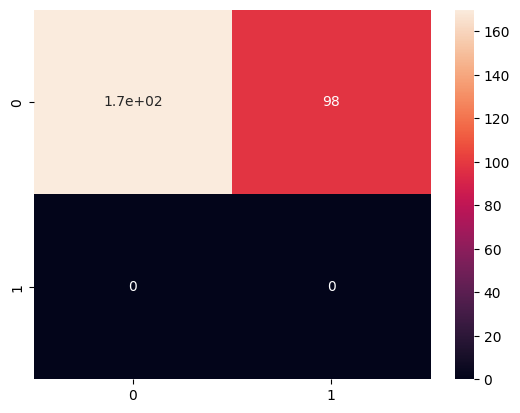





Evaluating model Bagging Classifier


              precision    recall  f1-score   support

           0       0.88      0.85      0.86       177
           1       0.72      0.78      0.75        91

    accuracy                           0.82       268
   macro avg       0.80      0.81      0.81       268
weighted avg       0.83      0.82      0.83       268



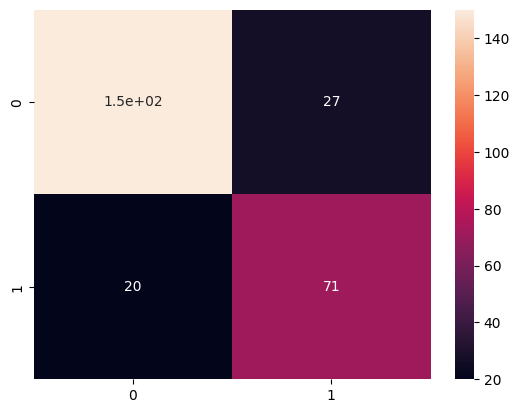





Evaluating model Random Forest Classifier


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       178
           1       0.76      0.82      0.79        90

    accuracy                           0.85       268
   macro avg       0.83      0.84      0.84       268
weighted avg       0.86      0.85      0.85       268



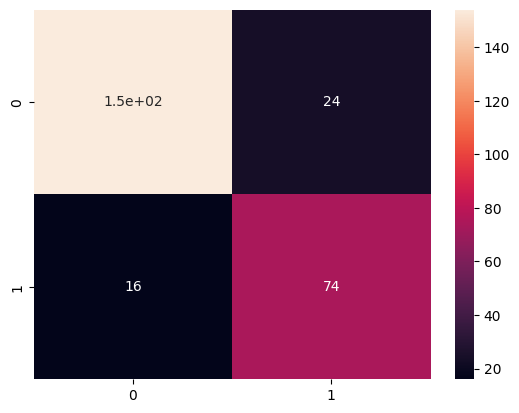





Evaluating model Decision Tree Classifier


              precision    recall  f1-score   support

           0       0.85      0.84      0.84       171
           1       0.72      0.73      0.73        97

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



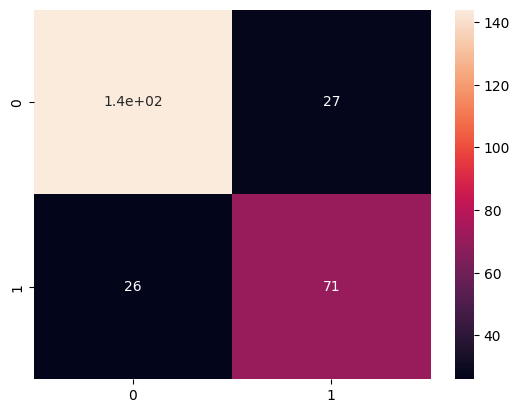





Evaluating model Logistic Regression


              precision    recall  f1-score   support

           0       0.86      0.83      0.84       176
           1       0.69      0.74      0.72        92

    accuracy                           0.80       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



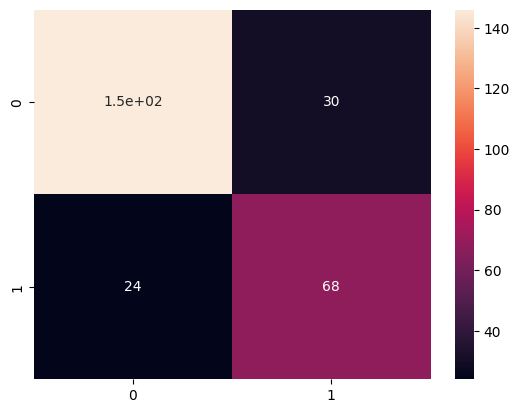

In [ ]:
for i, model_name in enumerate(model_names):
    print(f"Evaluating model {model_name}")
    model = models[i]
    y_pred2 = model.predict(X_test)
    print("\n")
    print(classification_report(y_pred2, y_test))
    display_confusion_matrix(y_pred2, y_test)
    print("\n\n\n")

## 8. Model Selection, Training and Kaggle Prediction Generation and Submissions

The next section reads the test dataset, applies the same preprocessing as for the training set, runs predictions and reformats csv file so it can be submitted to Kaggle.

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
X_val = test_df.copy()
preprocess_dataset(X_val)

In [ ]:
X_val.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,1,0.452723,0.015282,1,5,0
1,3,0,0.617566,0.013663,2,6,1
2,2,1,0.815377,0.018909,1,5,0
3,3,1,0.353818,0.016908,2,5,0
4,3,0,0.287881,0.023984,2,6,2


In [ ]:
y_val = lr_model.predict(X_val)

NameError: name 'lr_model' is not defined

In [ ]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_val})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
submission.to_csv('submission.csv', index=False)